# Machine Learning Model Development for Bliss Window Prediction

## Σύνοψη Διαδικασίας

Αυτό το notebook αναπτύσσει και αξιολογεί διάφορα μοντέλα μηχανικής μάθησης για την πρόβλεψη του **Bliss Window**, μιας μέτρησης που ποσοτικοποιεί τη συνεργιστική δράση φαρμακευτικών συνδυασμών στη θεραπεία του καρκίνου. Η διαδικασία περιλαμβάνει την εκπαίδευση πολλαπλών αλγορίθμων, την αξιολόγηση της απόδοσής τους, την επιλογή χαρακτηριστικών (feature selection), και την βελτιστοποίηση υπερπαραμέτρων (hyperparameter tuning) για να επιτευχθεί το βέλτιστο δυνατό προβλεπτικό μοντέλο.

Τα δεδομένα που χρησιμοποιούνται προέρχονται από το data cleaning pipeline (αρχείο `df_ml_model.csv`), όπου έχουν υποστεί ολοκληρωμένη προεπεξεργασία: imputation missing values, scaling με RobustScaler, one-hot encoding για κατηγορικές μεταβλητές χαμηλής cardinality, και target encoding για τη μεταβλητή `cellline_name`.

## Φόρτωση και Αρχική Διερεύνηση Συσχετίσεων

Το πρώτο βήμα μετά τη φόρτωση των δεδομένων είναι η κατανόηση των γραμμικών σχέσεων μεταξύ των μεταβλητών και της target μεταβλητής (`bliss_window`). Για αυτό το λόγο υπολογίζεται ο **συντελεστής συσχέτισης Pearson** για κάθε χαρακτηριστικό με το bliss_window.

Ο συντελεστής Pearson μετρά τη γραμμική συσχέτιση μεταξύ δύο μεταβλητών και κυμαίνεται από -1 (τέλεια αρνητική συσχέτιση) έως +1 (τέλεια θετική συσχέτιση). Τιμές κοντά στο 0 υποδηλώνουν ασθενή γραμμική σχέση. Αυτή η ανάλυση παρέχει μια πρώτη ένδειξη για το ποια χαρακτηριστικά μπορεί να είναι πιο σημαντικά για την πρόβλεψη, αν και πρέπει να σημειωθεί ότι:

1. Ο Pearson εντοπίζει μόνο **γραμμικές** σχέσεις - μη γραμμικές σχέσεις μπορεί να υπάρχουν αλλά να μην ανιχνεύονται
2. Η συσχέτιση δεν συνεπάγεται αιτιότητα
3. Αλγόριθμοι όπως τα tree-based μοντέλα μπορούν να αξιοποιήσουν και μη γραμμικές σχέσεις

Επιπλέον, γίνεται εξέταση των τύπων δεδομένων (`dtypes`) και του πλήθους μοναδικών τιμών ανά στήλη, για να επιβεβαιωθεί ότι το encoding και scaling έχουν εφαρμοστεί σωστά και δεν υπάρχουν απροσδόκητες κατηγορικές μεταβλητές που δεν έχουν κωδικοποιηθεί.

## Baseline Model: Dummy Regressor

Πριν αναπτυχθούν πολύπλοκα μοντέλα, είναι κρίσιμο να δημιουργηθεί ένα **baseline model** για να υπάρχει σημείο αναφοράς. Το baseline μοντέλο χρησιμεύει ως το "χειρότερο αποδεκτό" επίπεδο απόδοσης - οποιοδήποτε πιο σύνθετο μοντέλο πρέπει να ξεπερνά το baseline, αλλιώς δεν αξίζει τη πολυπλοκότητά του.

Χρησιμοποιείται ο **DummyRegressor** με στρατηγική `strategy='mean'`, που απλώς προβλέπει τον μέσο όρο της target μεταβλητής για όλες τις παρατηρήσεις, αγνοώντας εντελώς τα χαρακτηριστικά. Αυτό αντιστοιχεί στο να "μαντεύεις" πάντα την ίδια τιμή. Τα metrics που καταγράφονται είναι:
- **MSE (Mean Squared Error)**: Μέσο τετραγωνικό σφάλμα
- **MAE (Mean Absolute Error)**: Μέση απόλυτη απόκλιση
- **MedAE (Median Absolute Error)**: Διάμεσος απόλυτης απόκλισης

Η χρήση πολλαπλών metrics είναι σημαντική επειδή το MSE "τιμωρεί" πιο έντονα τα μεγάλα σφάλματα (λόγω τετραγωνισμού), ενώ το MAE και MedAE είναι πιο ανθεκτικά σε outliers.

## Αρχική Εκπαίδευση Πολλαπλών Αλγορίθμων

Δοκιμάζονται τέσσερις διαφορετικοί αλγόριθμοι regression με τις default υπερπαραμέτρους τους, για να αξιολογηθεί η καταλληλότητά τους για το συγκεκριμένο πρόβλημα:

### 1. Linear Regression
Το πιο απλό μοντέλο, που υποθέτει γραμμική σχέση μεταξύ των χαρακτηριστικών και της target. Λειτουργεί με τη μέθοδο ελαχίστων τετραγώνων (Ordinary Least Squares). Όπως φαίνεται από το σχόλιο "worst results", το μοντέλο αυτό δεν αποδίδει καλά, υποδεικνύοντας ότι οι σχέσεις στα δεδομένα είναι πιθανότατα **μη γραμμικές** ή περιέχουν πολύπλοκες αλληλεπιδράσεις που η γραμμική παλινδρόμηση δεν μπορεί να μοντελοποιήσει.

### 2. Random Forest Regressor
Ένα ensemble μοντέλο που συνδυάζει πολλαπλά decision trees (εδώ 100), εκπαιδευμένα σε διαφορετικά υποσύνολα δεδομένων με τη μέθοδο bagging. Κάθε tree μαθαίνει διαφορετικές πτυχές των δεδομένων, και η τελική πρόβλεψη είναι ο μέσος όρος των προβλέψεων όλων των trees. Το μοντέλο αυτό:
- Χειρίζεται καλά μη γραμμικές σχέσεις
- Είναι robust σε outliers
- Μπορεί να μοντελοποιήσει περίπλοκες αλληλεπιδράσεις μεταξύ χαρακτηριστικών
- Παρέχει feature importance scores

Παρατηρείται ότι τα metrics είναι "πολύ χαμηλά", που σημαίνει πολύ καλή απόδοση, κάτι που εγείρει ύποψη για πιθανό **overfitting**.

### 3. Gradient Boosting Regressor
Ένα άλλο ensemble μοντέλο, αλλά με διαφορετική προσέγγιση: αντί να εκπαιδεύει τα trees παράλληλα (bagging), τα εκπαιδεύει **σειριακά** (boosting). Κάθε νέο tree προσπαθεί να διορθώσει τα λάθη του προηγούμενου. Αυτή η τεχνική συνήθως οδηγεί σε υψηλότερη προβλεπτική ακρίβεια αλλά με κίνδυνο overfitting αν δεν ρυθμιστεί σωστά.

### 4. XGBoost Regressor
Μια εξελιγμένη υλοποίηση του gradient boosting, με βελτιστοποιήσεις για ταχύτητα και απόδοση. Περιλαμβάνει built-in regularization για αποφυγή overfitting και έχει πρόσθετες δυνατότητες όπως handling missing values και parallel processing.

## Feature Importance Analysis και Feature Selection

Μετά την αρχική εκπαίδευση, χρησιμοποιούνται τα **feature importances** του Random Forest για να αξιολογηθεί η σχετική σημασία κάθε χαρακτηριστικού. Το feature importance στο Random Forest υπολογίζεται με βάση το πόσο μειώνεται το σφάλμα (impurity) όταν γίνεται split σε ένα συγκεκριμένο χαρακτηριστικό, усреднενный σε όλα τα trees.

Τα αποτελέσματα ταξινομούνται φθίνοντα και οπτικοποιούνται με bar plot για τα top 15 χαρακτηριστικά. Η ανάλυση αυτή αποκαλύπτει ότι η μεταβλητή `cellline_name` έχει **υπερβολικά υψηλή** σημασία σε σχέση με τα υπόλοιπα χαρακτηριστικά. Αυτή η τεράστια διαφορά είναι ένδειξη **overfitting**: το μοντέλο "απομνημονεύει" τη συμπεριφορά συγκεκριμένων κυτταρικών σειρών αντί να μαθαίνει γενικεύσιμα patterns.

Για αντιμετώπιση του προβλήματος, λαμβάνεται η απόφαση να **αφαιρεθεί η cellline_name** και να κρατηθούν τα επόμενα 14 πιο σημαντικά χαρακτηριστικά. Αυτή η προσέγγιση:
- Μειώνει τη διαστατικότητα του προβλήματος
- Απλοποιεί το μοντέλο
- Αναμένεται να βελτιώσει τη **γενικευσιμότητα** (generalization)
- Μειώνει τον κίνδυνο overfitting

Το reduced dataset (`X_reduced`) με τα 14 χαρακτηριστικά χρησιμοποιείται για την περαιτέρω ανάλυση.

## Επαναξιολόγηση με Reduced Features

Με το μειωμένο σύνολο χαρακτηριστικών, εκπαιδεύονται ξανά τα μοντέλα:
- Το **Dummy Model** παρέχει νέο baseline
- Τα **Gradient Boosting** και **XGBoost** δοκιμάζονται ξανά
- Το **Random Forest** με τα reduced features εμφανίζει καλή ισορροπία μεταξύ απόδοσης και γενικευσιμότητας

Τα αποτελέσματα συγκρίνονται με το baseline για να επιβεβαιωθεί ότι το μοντέλο προσθέτει πραγματική προβλεπτική αξία.

## Hyperparameter Optimization

Για να βελτιωθεί περαιτέρω η απόδοση του Gradient Boosting, που φαίνεται υποσχόμενο, εφαρμόζονται τρεις διαφορετικές τεχνικές βελτιστοποίησης:

### 1. Grid Search
Δοκιμάζει **όλους τους δυνατούς συνδυασμούς** των υπερπαραμέτρων από προκαθορισμένα grids:
- `n_estimators`: [100, 200, 300] - πλήθος trees
- `learning_rate`: [0.01, 0.1, 0.2] - ρυθμός μάθησης
- `max_depth`: [3, 5, 7] - μέγιστο βάθος κάθε tree
- `subsample`: [0.7, 0.8, 1.0] - ποσοστό δειγμάτων για κάθε tree

Χρησιμοποιεί **3-fold cross-validation** για να αξιολογηθεί κάθε συνδυασμός. Είναι exhaustive αλλά μπορεί να είναι χρονοβόρο.

### 2. Randomized Search
Αντί να δοκιμάσει όλους τους συνδυασμούς, **δειγματοληπτεί τυχαία** 20 συνδυασμούς από τα ranges των υπερπαραμέτρων. Είναι πιο γρήγορο από το Grid Search και συχνά βρίσκει εξίσου καλές λύσεις, ειδικά όταν ο χώρος αναζήτησης είναι μεγάλος.

### 3. Bayesian Optimization (BayesSearchCV)
Η πιο εξελιγμένη μέθοδος, που χρησιμοποιεί **πιθανοτικό μοντέλο** για να προβλέψει ποιοι συνδυασμοί υπερπαραμέτρων είναι πιθανότερο να δώσουν καλά αποτελέσματα. Μαθαίνει από τις προηγούμενες δοκιμές και επικεντρώνει την αναζήτηση σε υποσχόμενες περιοχές του χώρου. Είναι πιο αποδοτική από τις άλλες μεθόδους όταν η αξιολόγηση είναι δαπανηρή.

## Cross-Validation για Αξιολόγηση Γενικευσιμότητας

Μετά την εύρεση των βέλτιστων υπερπαραμέτρων, εφαρμόζεται **cross-validation** με 5 και 8 folds για να αξιολογηθεί η **γενικευσιμότητα** του μοντέλου. Το cross-validation:
- Διαιρεί τα δεδομένα σε K folds (υποσύνολα)
- Εκπαιδεύει το μοντέλο K φορές, κάθε φορά χρησιμοποιώντας K-1 folds για training και 1 fold για testing
- Υπολογίζει τον **μέσο όρο και την τυπική απόκλιση** των metrics

Η τυπική απόκλιση είναι ιδιαίτερα σημαντική: χαμηλή τυπική απόκλιση σημαίνει ότι το μοντέλο είναι **σταθερό** και δεν επηρεάζεται πολύ από το ποια δεδομένα χρησιμοποιούνται για training.

## Περαιτέρω Feature Reduction και Τελικό Μοντέλο

Αφαιρούνται επιπλέον τρία χαρακτηριστικά που σχετίζονται με συγκεκριμένους τύπους καρκίνου και ιστούς (`cancer_type_Lung Adenocarcinoma`, `tissue_Lung`, `cancer_type_Colorectal Carcinoma`), δημιουργώντας το `X_reduced_twice` με 11 χαρακτηριστικά.

Το **τελικό μοντέλο Random Forest** με αυτά τα 11 χαρακτηριστικά επιτυγχάνει:
- **MSE: 0.428**
- **RMSE: 0.654**
- **MAE: 0.508**
- **MedAE: 0.418**

Εφαρμόζεται 5-fold cross-validation με πολλαπλά metrics (MSE και MAE) για να επιβεβαιωθεί η σταθερότητα της απόδοσης.

## Αξιολόγηση και Ερμηνεία Αποτελεσμάτων

Η οπτικοποίηση με **scatter plot** των πραγματικών έναντι των προβλεπόμενων τιμών επιτρέπει την οπτική επιθεώρηση της απόδοσης. Τέλεια πρόβλεψη θα έδειχνε όλα τα σημεία στην κόκκινη διαγώνιο (y=x line).

Η τελική αξιολόγηση λαμβάνει υπόψη το **εύρος τιμών** του bliss_window:
- **Minimum**: ~-1.8
- **Maximum**: ~3.9
- **Εύρος**: ~5.7 μονάδες

Με **MAE = 0.508**, το μέσο σφάλμα αντιστοιχεί σε **~9% του συνολικού εύρους**, που θεωρείται ικανοποιητική έως καλή απόδοση για βιολογικά δεδομένα.

Το **MedAE = 0.418** είναι ακόμα πιο ενθαρρυντικό, υποδεικνύοντας ότι η διάμεσος σφάλματος είναι μικρότερη από το MAE, πράγμα που σημαίνει ότι οι περισσότερες προβλέψεις είναι αρκετά ακριβές, με μερικά outliers που ανεβάζουν το MAE.

Σημαντική είναι και η **σύγκριση με το Dummy Model**:
- Dummy MAE: 0.618
- Final Model MAE: 0.508
- **Βελτίωση: ~18%**

Αυτό αποδεικνύει ότι το μοντέλο έχει μάθει χρήσιμα patterns από τα δεδομένα και δεν απλώς "μαντεύει". Το τελικό μοντέλο είναι ένα **γενικεύσιμο, robust Random Forest regressor** που ισορροπεί μεταξύ προβλεπτικής ακρίβειας και αποφυγής overfitting, κατάλληλο για πρόβλεψη της συνεργιστικής δράσης φαρμάκων σε νέους συνδυασμούς.

In [1]:
import pandas as pd
import numpy as np
from py2neo import Graph
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from spicy import stats as stats
from sklearn.preprocessing import RobustScaler
import category_encoders as ce
import ast
import os, datetime
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

In [2]:
#Locally καθάρισα τα ονοματα των στηλών στο excel
file_path= 'df_ml_model.csv'
df= pd.read_csv(file_path)
df.head(2)

,bliss_window,combo_maxe,day1_inhibition_scale,day1_intensity_mean,day1_viability_mean,doubling_time,drug1_ic50_ln,drug1_maxe,drug2_ic50_ln,drug2_maxe,...,tissue_Pancreas,tissue_Peripheral Nervous System,tissue_Prostate,tissue_Skin,tissue_Soft Tissue,tissue_Stomach,tissue_Testis,tissue_Thyroid,tissue_Uterus,tissue_Vulva
0,0.128684,0.546636,-0.045646,-0.673093,0.045646,0.110726,-0.890523,1.012658,-0.104884,0.221689,...,0,0,0,0,0,0,0,0,0,0
1,-0.375355,-0.160556,-1.635435,0.635934,1.635435,14.469871,-0.397468,0.422753,-0.614549,0.791633,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#Ένα πρωτο check με Pearson για το ποιες τιμές συσχετίζονται πιο πολυ με το bliss window
pd.set_option('display.max_rows', None) 
correlation_with_bliss_window = df.corr(method='pearson')['bliss_window'].sort_values(ascending=False)
print(correlation_with_bliss_window)

bliss_window                                      1.000000
cellline_name                                     0.897723
combo_maxe                                        0.427263
drug2_maxe                                        0.397431
tissue_Haematopoietic and Lymphoid                0.271388
growth_rate                                       0.229936
drug1_maxe                                        0.201437
day1_inhibition_scale                             0.196852
cancer_type_T-Lymphoblastic Leukemia              0.183757
cancer_type_Ewing's Sarcoma                       0.159116
cancer_type_B-Cell Non-Hodgkin's Lymphoma         0.115613
tissue_Peripheral Nervous System                  0.098234
cancer_type_Neuroblastoma                         0.098234
tissue_Bone                                       0.095362
cancer_type_Plasma Cell Myeloma                   0.089705
cancer_type_Chronic Myelogenous Leukemia          0.083468
cancer_type_B-Lymphoblastic Leukemia              0.0800

In [136]:
# Τύποι δεδομένων ανά στήλη και δείγμα μοναδικών τιμών
print('Dtypes:')
print(df.dtypes)

print('\nΣύνοψη ανά στήλη:')
for col in df.columns:
    ser = df[col]
    dtype = ser.dtype
    nunique = ser.nunique(dropna=True)
    sample_vals = ser.dropna().unique()[:5]
    print(f'- {col}: dtype={dtype}, unique={nunique}, sample={sample_vals}')

Dtypes:
bliss_window                                      float64
combo_maxe                                        float64
day1_inhibition_scale                             float64
day1_intensity_mean                               float64
day1_viability_mean                               float64
doubling_time                                     float64
drug1_ic50_ln                                     float64
drug1_maxe                                        float64
drug2_ic50_ln                                     float64
drug2_maxe                                        float64
growth_rate                                       float64
cellline_name                                     float64
tpm_value                                         float64
tpm_value_raw                                      object
cancer_type_B-Cell Non-Hodgkin's Lymphoma           int64
cancer_type_B-Lymphoblastic Leukemia                int64
cancer_type_Biliary Tract Carcinoma                 int64
cancer

In [4]:
#Dummy Model για να χρησιμοποιήσω ως baseline

X = df.drop(columns=['bliss_window'])
y = df['bliss_window']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)

ypred = dummy.predict(X_test)
mse = mean_squared_error(y_test, ypred)
dummy_mae = mean_absolute_error(y_test, ypred)
dummy_med = median_absolute_error(y_test, ypred)
print(f'Dummy Model MSE: {mse}')
print(f'Dummy Model MAE: {dummy_mae}')
print(f'Dummy Model MedAE: {dummy_med}')

Dummy Model MSE: 0.5938578531605603
Dummy Model MAE: 0.6182762289400249
Dummy Model MedAE: 0.5078487117852382


In [5]:
#Linear Regression Model

lr=LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Linear Regression Model MSE: {mse_lr}')
print(f'Linear Regression Model MAE: {mae}')
#worst results

Linear Regression Model MSE: 2.4814343681842335
Linear Regression Model MAE: 0.3977571946510875


In [7]:
#Random Forest Model

X = df.drop(columns=['bliss_window'])
y = df['bliss_window']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf= RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Random Forest Model MSE: {mse_rf}')
print(f'Random Forest Model MAE: {mae}')

#πολυ χαμηλα metrics

Random Forest Model MSE: 0.09834268337371706
Random Forest Model MAE: 0.12358647516343499


In [7]:
#Gradient Boosting Model
X = df.drop(columns=['bliss_window'])
y = df['bliss_window']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr= GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)
mse_gbr = mean_squared_error(y_test, gbr_pred)
mae = mean_absolute_error(y_test, gbr_pred)
print(f'Gradient Boosting Model MSE: {mse_gbr}')
print(f'Gradient Boosting Model MAE: {mae}')

Gradient Boosting Model MSE: 0.08915952183874046
Gradient Boosting Model MAE: 0.13782248374828945


In [118]:
#XGBRegressor
X = df.drop(columns=['bliss_window'])
y = df['bliss_window']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb= XGBRegressor(random_state=42, eval_metric='rmse')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, xgb_pred)
mae = mean_absolute_error(y_test, xgb_pred)
print(f'XGB Regressor Model MSE: {mse_xgb}')
print(f'XGB Regressor Model MAE: {mae}')

XGB Regressor Model MSE: 0.1192364820660419
XGB Regressor Model MAE: 0.15913959221127283


In [8]:
X = df.drop(columns=['bliss_window'])
y = df['bliss_window']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
#Optimization

importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                                           Feature    Importance
10                                   cellline_name  9.010026e-01
0                                       combo_maxe  1.684770e-02
2                              day1_intensity_mean  9.458932e-03
5                                    drug1_ic50_ln  9.046636e-03
11                                       tpm_value  8.188448e-03
8                                       drug2_maxe  7.675239e-03
33                 cancer_type_Lung Adenocarcinoma  6.371309e-03
7                                    drug2_ic50_ln  6.209095e-03
6                                       drug1_maxe  5.591464e-03
3                              day1_viability_mean  5.514474e-03
1                            day1_inhibition_scale  4.566733e-03
9                                      growth_rate  4.325651e-03
4                                    doubling_time  4.000506e-03
66                                     tissue_Lung  2.089512e-03
21                cancer_

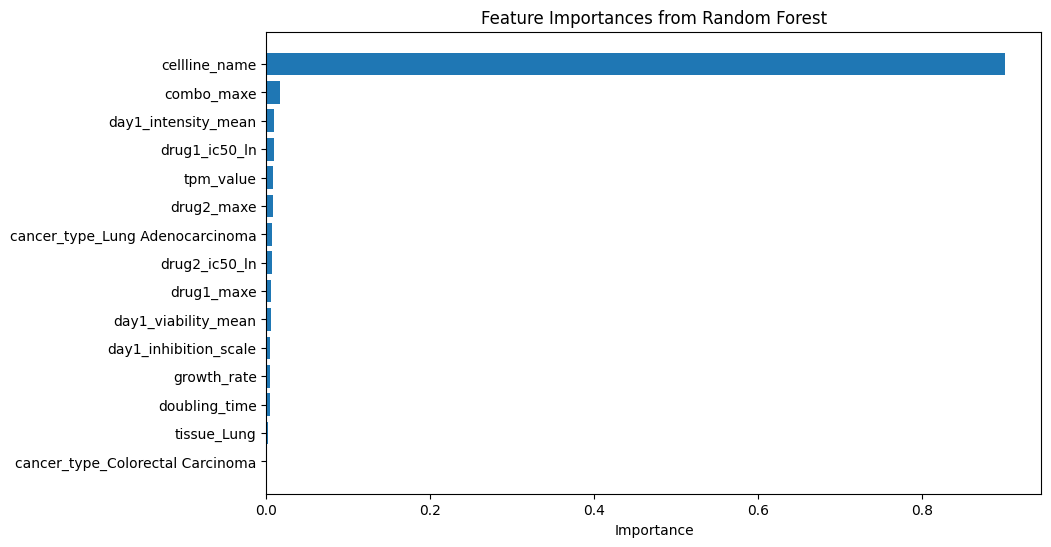

In [10]:
top_features = feature_importance_df.head(15)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.show()

In [11]:
#Κρατάω τα τοπ 14 features, αφαιρω το celline, με τοση διαφορα, κανει Overfit το μοντελο
top_15 = feature_importance_df.head(15)
top_14 = top_15.iloc[1:]

features_to_keep = top_14['Feature'].tolist()

X_reduced = X[features_to_keep]
print(X_reduced.head(2))

   combo_maxe  day1_intensity_mean  drug1_ic50_ln  tpm_value  drug2_maxe  \
0    0.546636            -0.673093      -0.890523  -0.087819    0.221689   
1   -0.160556             0.635934      -0.397468   0.893952    0.791633   

   cancer_type_Lung Adenocarcinoma  drug2_ic50_ln  drug1_maxe  \
0                                0      -0.104884    1.012658   
1                                0      -0.614549    0.422753   

   day1_viability_mean  day1_inhibition_scale  growth_rate  doubling_time  \
0             0.045646              -0.045646    -0.028261       0.110726   
1             1.635435              -1.635435    -1.086961      14.469871   

   tissue_Lung  cancer_type_Colorectal Carcinoma  
0            0                                 0  
1            0                                 0  


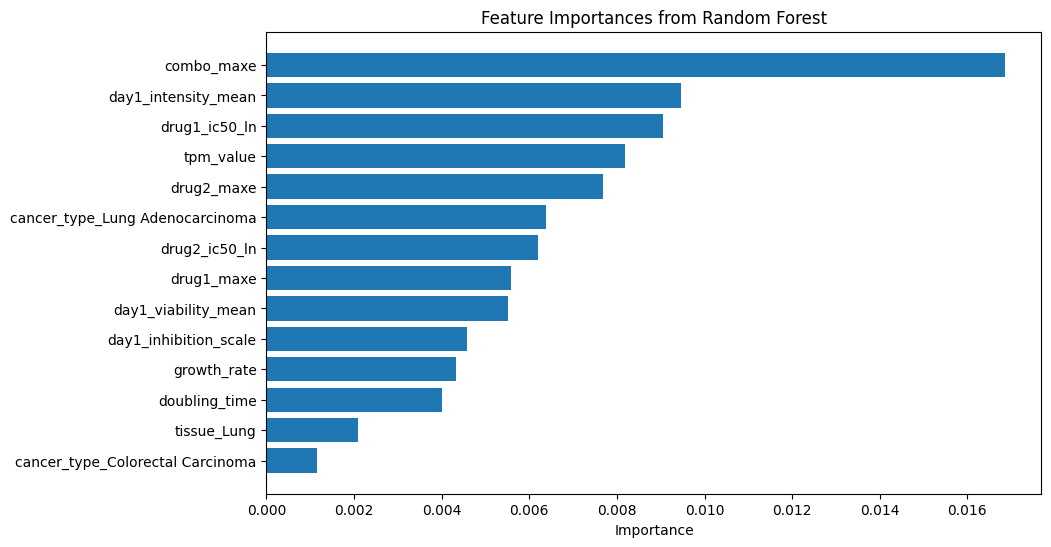

In [13]:
top_features_no_cellline = top_features[top_features['Feature'] != 'cellline_name']
plt.figure(figsize=(10, 6))
plt.barh(top_features_no_cellline['Feature'], top_features_no_cellline['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.show()

In [123]:
#Dummy Model για να χρησιμοποιήσω ως baseline με τα 14 features

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)

ypred = dummy.predict(X_test)
mse = mean_squared_error(y_test, ypred)
dummy_mae = mean_absolute_error(y_test, ypred)
print(f'Dummy Model MSE: {mse}')
print(f'Dummy Model MAE: {dummy_mae}')

Dummy Model MSE: 0.5938578531605603
Dummy Model MAE: 0.6182762289400249


In [11]:
#Gradient Boosting Model with reduced

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

gbr= GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)
mse_gbr = mean_squared_error(y_test, gbr_pred)
print(f'Gradient Boosting Model MSE: {mse_gbr}')
rmse= np.sqrt(mse_gbr)
print(f'Gradient Boosting Model RMSE: {rmse}')
mae = mean_absolute_error(y_test, gbr_pred)
print(f'Gradient Boosting Model MAE: {mae}')

Gradient Boosting Model MSE: 0.4426529616806759
Gradient Boosting Model RMSE: 0.6653216978880787
Gradient Boosting Model MAE: 0.5235704766905098


In [12]:
#XGBRegressor with reduced

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

xgb= XGBRegressor(random_state=42, eval_metric='rmse')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, xgb_pred)
mae = mean_absolute_error(y_test, xgb_pred)
print(f'XGB Regressor Model MSE: {mse_xgb}')
print(f'XGB Regressor Model MAE: {mae}')

XGB Regressor Model MSE: 0.5154158849487042
XGB Regressor Model MAE: 0.5443349620855169


In [13]:
#Random Forest Model with reduced

rf= RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred)
print(f'Random Forest Model MSE: {mse_rf}')
rmse= np.sqrt(mse_rf)
print(f'Random Forest Model RMSE: {rmse}')
mae = mean_absolute_error(y_test, y_pred)
print(f'Random Forest Model MAE: {mae}')

Random Forest Model MSE: 0.4344545290788565
Random Forest Model RMSE: 0.6591316477600332
Random Forest Model MAE: 0.5152277403525548


In [127]:
#Optimize Gradient Boosting specifically with Grid Search

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7,0.8, 1.0],
}

gbr = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print('Best MSE: ', -grid_search.best_score_)

Best parameters found:  {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}
Best MSE:  0.44406336130015295


In [128]:
#Cross-validation 5-fold with the best model from Grid Search

gbr= GradientBoostingRegressor(**grid_search.best_params_, random_state=42)

scores = cross_val_score(gbr, X_reduced, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
print(f'Cross-validated MSE scores: {mse_scores}')
print(f'Average Cross-validated MSE: {np.mean(mse_scores)}')
print(f'Std of Cross-validated MSE: {np.std(mse_scores)}')

Cross-validated MSE scores: [0.43416933 0.60095918 0.48420889 0.4046747  0.45185499]
Average Cross-validated MSE: 0.47517341877005936
Std of Cross-validated MSE: 0.06796889246163082


In [129]:
#Cross-validation 8-fold with the best model from Grid Search

gbr= GradientBoostingRegressor(**grid_search.best_params_, random_state=42)

scores = cross_val_score(gbr, X_reduced, y, cv=8, scoring='neg_mean_squared_error')

mse_scores = -scores
print(f'Cross-validated MSE scores: {mse_scores}')
print(f'Average Cross-validated MSE: {np.mean(mse_scores)}')
print(f'Std of Cross-validated MSE: {np.std(mse_scores)}')

Cross-validated MSE scores: [0.45626194 0.41230883 0.53811874 0.58536616 0.40808168 0.43790699
 0.34009176 0.5130629 ]
Average Cross-validated MSE: 0.46139987614498396
Std of Cross-validated MSE: 0.07455637465765819


In [52]:
#Randomized Search

param_dist={
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.3],
    'max_depth': [3, 10]
}

gbr= GradientBoostingRegressor(random_state=42)

random_search= RandomizedSearchCV(estimator=gbr, param_distributions=param_dist, n_iter=20, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)

random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print('Best MSE: ', -random_search.best_score_)

c:\Users\chrisk41\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01}
Best MSE:  0.46063188997947274


In [54]:
#Bayesian Optimization

param_space = {
    'n_estimators': (100, 500),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'max_depth': (3, 10)
}

gbr = GradientBoostingRegressor(random_state=42)

bayes_search = BayesSearchCV(estimator=gbr, search_spaces=param_space, n_iter=25, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)

bayes_search.fit(X_train, y_train)

print("Best parameters found: ", bayes_search.best_params_)
print('Best MSE: ', -bayes_search.best_score_)

c:\Users\chrisk41\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01, 3, 500] before, using random point [0.01902689882566251, 5, 404]
  warnings.warn(
c:\Users\chrisk41\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01, 3, 500] before, using random point [0.0400267560875864, 9, 404]
  warnings.warn(
c:\Users\chrisk41\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01, 3, 500] before, using random point [0.037514670110218834, 4, 282]
  warnings.warn(
c:\Users\chrisk41\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01, 3, 500] before, using random point [0.026991713368769498, 4, 359]


Best parameters found:  OrderedDict([('learning_rate', 0.01), ('max_depth', 3), ('n_estimators', 382)])
Best MSE:  0.4600658976460255


In [14]:
#Θα βγαλω λιγα ακομα columns απο το dataset μου
X_reduced_twice = X_reduced.drop(columns=['cancer_type_Lung Adenocarcinoma', 'tissue_Lung','cancer_type_Colorectal Carcinoma'])
X_reduced_twice.columns

Index(['combo_maxe', 'day1_intensity_mean', 'drug1_ic50_ln', 'tpm_value',
       'drug2_maxe', 'drug2_ic50_ln', 'drug1_maxe', 'day1_viability_mean',
       'day1_inhibition_scale', 'growth_rate', 'doubling_time'],
      dtype='object')

In [15]:
#Random Forest Model with reduced twice
X_train, X_test, y_train, y_test = train_test_split(X_reduced_twice, y, test_size=0.2, random_state=42)

rf_reduced_twice= RandomForestRegressor(n_estimators=100, random_state=42)
rf_reduced_twice.fit(X_train, y_train)
y_pred = rf_reduced_twice.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred)
print(f'Random Forest Model MSE: {mse_rf}')
rmse= np.sqrt(mse_rf)
print(f'Random Forest Model RMSE: {rmse}')
mae = mean_absolute_error(y_test, y_pred)
print(f'Random Forest Model MAE: {mae}')
medae = median_absolute_error(y_test, y_pred)
print(f'Random Forest Model MedAE: {medae}')

Random Forest Model MSE: 0.4280976837497038
Random Forest Model RMSE: 0.6542917420766549
Random Forest Model MAE: 0.5082816409788604
Random Forest Model MedAE: 0.4182746945473723


In [102]:
#Cross-validation 8-fold with the best model so far

scoring={'MSE': 'neg_mean_squared_error', 'MAE': 'neg_mean_absolute_error'}

cv_results = cross_validate(rf_reduced_twice, X_reduced_twice, y, cv=5, scoring=scoring, return_train_score=True)

mse_scores = -cv_results['test_MSE']
mae_scores = -cv_results['test_MAE']
print(f'Cross-validated MSE scores: {mse_scores}')
print(f'Average Cross-validated MSE: {np.mean(mse_scores)}')
print(f'Std of Cross-validated MSE: {np.std(mse_scores)}')
print(f'Cross-validated MAE scores: {mae_scores}')
print(f'Average Cross-validated MAE: {np.mean(mae_scores)}')
print(f'Std of Cross-validated MAE: {np.std(mae_scores)}')

Cross-validated MSE scores: [0.44156029 0.57288025 0.50537128 0.39196657 0.4626821 ]
Average Cross-validated MSE: 0.47489209650180886
Std of Cross-validated MSE: 0.06110219913115614
Cross-validated MAE scores: [0.49200902 0.57793195 0.53224696 0.49110335 0.49948624]
Average Cross-validated MAE: 0.5185555035804686
Std of Cross-validated MAE: 0.0332715838443909


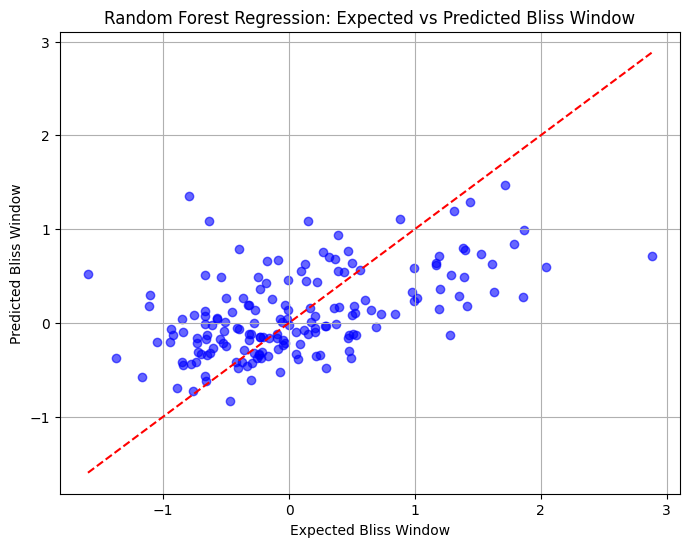

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Expected Bliss Window')
plt.ylabel('Predicted Bliss Window')
plt.title('Random Forest Regression: Expected vs Predicted Bliss Window')
plt.grid(True)
plt.show()

In [82]:
print("Bliss window min",y.min())
print("Bliss window max",y.max())
print("Bliss window mean",y.mean())

Bliss window min -1.790162581
Bliss window max 3.9411349787443632
Bliss window mean 0.12311137767170968


In [ ]:
#Τα κελυτερα αποτελέσματα στο πιο γενικευσιμο μοντελο ειναι
# Random Forest Model MSE: 0.4280976837497038
# Random Forest Model RMSE: 0.6542917420766549
# Random Forest Model MAE: 0.5082816409788604
# Random Forest Model MedAE: 0.4182746945473723

#Επειδη δεν εχουμε αφαιρεσει τα outliers, θα χρησιμοποιησουμε το MAE και MedAE για να αξιολογησουμε το μοντελο μας.
#Κυρίως το δευτερο ειναι πιο ανθεκτικο σε ακραιες τιμες.

#Η κλίμακα του bliss window ειναι απο περιπου -1.8 εως 3.9
#αρα συνολικο ευρος 5.7 μοναδες

#Κατα μεσο ορο οι προβλεψεις απεχουν 0.51 μοναδες απο τη πραγματικη τιμη.
#Το σφαλμα αυτο αντιστοιχει περιπου σε 9% του συνολικου ευρους τιμων.
#Απο αποψη της κλιμακας το ΜΑΕ μας θεωρειται ικανοποιητικο εως καλο.

#Επίσης έχουμε σιγουρα καλυτερα αποτελεσματα απο το Dummy Model που ειχαμε στην αρχη. 
# Dummy Model MAE: 0.6182762289400249
# Dummy Model MedAE: 0.5078487117852382

In [ ]:
scatterplot expected vs predicted
na dokimasw ena modelo me allo syndiasmo farmakwn